<a href="https://colab.research.google.com/github/Ksenia-90/probability_theory/blob/lesson_8_project/project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Курсовая работа**

##**Тема: "Анализ средней продолжительности фильма в зависимости от жанра"**

Данные для исследования и анализа взяты из открытого источника: 
* https://www.imdb.com/interfaces/ 
* https://datasets.imdbws.com/

**Выдвинем 2 гипотизы:**
* **Гипотеза H0: средняя продолжительность фильма не зависит от жанра**
* **Гипотеза H1: средняя продолжительность фильма зависит от жанра.**

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import preprocessing
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

%matplotlib inline

In [44]:
def target_genres(data, target):
    target_genres = []
    for genre in data:
        tmp_list = str(genre).lower().split(',') 
        for item in tmp_list:
            if item in target:
                target_genres.append(str(genre))
    return target_genres

In [45]:
def balanset_by_column(df, column_name, values):
    min_count = len(df)
    for i in values:
        res = df[df[column_name] == i].count()[column_name]
        if res < min_count:
            min_count = res
    return pd.concat(map(lambda value : df.query(column_name + " == " + str(value)).sample(n=min_count), values))

In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
titel = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/title.basics.tsv.gz', sep = '\t', encoding='utf-8' )

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [48]:
titel.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


In [49]:
print(titel.shape)

(8300681, 9)


In [50]:
print(list(titel.columns))

['tconst', 'titleType', 'primaryTitle', 'originalTitle', 'isAdult', 'startYear', 'endYear', 'runtimeMinutes', 'genres']


Выбирем только категорию 'Movie'

In [51]:
title_types = titel.titleType.unique()
print(title_types)

['short' 'movie' 'tvEpisode' 'tvSeries' 'tvShort' 'tvMovie' 'tvMiniSeries'
 'tvSpecial' 'video' 'videoGame' 'radioEpisode' 'tvPilot']


In [52]:
movies = titel[titel.titleType == 'movie']
print(movies.shape)
movies.head()


(589259, 9)


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
498,tt0000502,movie,Bohemios,Bohemios,0,1905,\N,100,\N
570,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"Action,Adventure,Biography"
587,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1907,\N,90,Drama
610,tt0000615,movie,Robbery Under Arms,Robbery Under Arms,0,1907,\N,\N,Drama
625,tt0000630,movie,Hamlet,Amleto,0,1908,\N,\N,Drama


In [53]:
#удалим записи которые содержат NaN
movies = movies.dropna()
movies = movies[movies.runtimeMinutes != '\\N']
movies['runtimeMinutes'] = movies['runtimeMinutes'].apply(lambda x: int(x))
movies = movies[movies.genres != '\\N']

In [54]:
#удаляем колонки котрые в данном расчете для нас не значимы.
movies.drop(movies.columns [[3,4, 5, 6]], axis = 1, inplace = True)

In [55]:
# выберем только те фильмы, продолжительность которых от 90 до 240 минут.
movies = movies[(movies.runtimeMinutes > 89) & (movies.runtimeMinutes < 241)]
movies.head()

,tconst,titleType,primaryTitle,runtimeMinutes,genres
587,tt0000591,movie,The Prodigal Son,90,Drama
672,tt0000679,movie,The Fairylogue and Radio-Plays,120,"Adventure,Fantasy"
2076,tt0002101,movie,Cleopatra,100,"Drama,History"
2418,tt0002445,movie,Quo Vadis?,120,"Drama,History"
2425,tt0002452,movie,The Independence of Romania,120,"History,War"


In [56]:
genres = tuple(movies.genres.unique())
print(genres[:25])

('Drama', 'Adventure,Fantasy', 'Drama,History', 'History,War', 'Crime,Drama,Mystery', 'Biography,Drama,History', 'Adventure,Drama,History', 'Crime,Drama', 'Action', 'Action,Adventure,Biography', 'Action,Adventure,Drama', 'Drama,Western', 'Drama,History,War', 'Drama,Sci-Fi', 'Crime,Drama,Horror', 'Documentary,War', 'Comedy', 'Action,Adventure,Sci-Fi', 'Documentary', 'Drama,History,Romance', 'Action,Drama,War', 'Adventure', 'Mystery', 'History', 'Adventure,Fantasy,Sci-Fi')


In [57]:
columns = ['tconst', 'primaryTitle', 'runtimeMinutes', 'genres']

fantasy_genres = target_genres(data=genres, target=('fantasy'))
fantasy_movies = movies[movies.genres.isin(fantasy_genres)].loc[:, columns].reset_index(drop=True)

horror_genres = target_genres(data=genres, target=('horror'))
horror_movies = movies[movies.genres.isin(horror_genres)].loc[:, columns].reset_index(drop=True)

action_genres = target_genres(data=genres, target=('action'))
action_movies = movies[movies.genres.isin(action_genres)].loc[:, columns].reset_index(drop=True)

In [58]:
fantasy = tuple(set(fantasy_movies.tconst) - set(horror_movies.tconst) - set(action_movies.tconst))
horror = tuple(set(horror_movies.tconst) - set(fantasy_movies.tconst) - set(action_movies.tconst))
action = tuple(set(action_movies.tconst) - set(fantasy_movies.tconst) - set(horror_movies.tconst))

Очистим жанры выбрав один тип

In [59]:
fantasy_only = fantasy_movies[fantasy_movies.tconst.isin(fantasy)].reset_index(drop=True)
fantasy_only['genres'] = 'fantasy'

horror_only = horror_movies[horror_movies.tconst.isin(horror)].reset_index(drop=True)
horror_only['genres'] = 'horror'

action_only = action_movies[action_movies.tconst.isin(action)].reset_index(drop=True)
action_only['genres'] = 'action'

In [60]:
print(f'fantasy_only  =  {fantasy_only.shape[0]}')
print(f'horror_only =  {horror_only.shape[0]}')
print(f'action_only  = {action_only.shape[0]}')

fantasy_only  =  3815
horror_only =  8392
action_only  = 18776


Возьмем из каждой группы по 3000 наблюдений.

In [61]:
n_sample = 3000

y_fantasy = fantasy_only.sample(n=n_sample, random_state=42).runtimeMinutes.values
y_horror= horror_only.sample(n=n_sample, random_state=42).runtimeMinutes.values
y_action = action_only.sample(n=n_sample, random_state=42).runtimeMinutes.values

In [62]:
y_fantasy_mean = y_fantasy.mean()
y_horror_mean = y_horror.mean()
y_action_mean = y_action.mean()
print(f'Cреднее значение:') 
print(f'y_fantasy_mean = {np.round(y_fantasy_mean, 3)}')
print(f'y_horror_mean =  {np.round(y_horror_mean, 3)}')
print(f'y_action_mean   =  {np.round(y_action_mean, 3)}')

Cреднее значение:
y_fantasy_mean = 106.495
y_horror_mean =  100.802
y_action_mean   =  111.868


In [63]:
films = np.concatenate([y_fantasy, y_horror, y_action])
films_mean = np.mean(films)
print(f'Cреднее значение общее {np.round(films_mean, 3)}')

Cреднее значение общее 106.388


In [64]:
n_1 = len(y_fantasy)
n_2 = len(y_horror)
n_3 = len(y_action)

n = n_1 + n_2 + n_3
k = 3

print(f'Общее значение: {n}')

Общее значение: 9000


In [65]:
S2_b = n_1 * (y_fantasy_mean - films_mean) ** 2 + n_2 * (y_horror_mean - films_mean) ** 2 + n_3 * (y_action_mean - films_mean) ** 2
print(f'S2_b = {np.round(S2_b, 3)}')

S2_b = 183758.08


In [66]:
S2_w = ((y_fantasy - y_fantasy_mean)**2).sum() + ((y_horror - y_horror_mean) ** 2).sum() + ((y_action - y_action_mean) ** 2).sum()
print(f'S2_w = {np.round(S2_w, 3)}')

S2_w = 3319831.918


In [67]:
S2_b + S2_w, ((films - films_mean) ** 2).sum()

(3503589.9982222226, 3503589.998222222)

In [68]:
k = 3
n = n_1 + n_2 + n_3
k_1 = k-1
k_2 = n - k
k_1, k_2, n

(2, 8997, 9000)

In [69]:
sigma2_b = S2_b / (k - 1)
sigma2_w = S2_w / (n - k)

sigma2_b, sigma2_w

(91879.04011111129, 368.99321084806047)

In [70]:
T = sigma2_b / sigma2_w
T

248.99926993221595

In [71]:
alpha = 0.05
F_crit = stats.f.ppf(1 - alpha, (k - 1), (n - k))
F_crit

2.9967299843896065

In [72]:
p = 1 - stats.f.cdf(T, k_1,k_2)
p

1.1102230246251565e-16

**Вывод:Согласно проведенному анализу мы принимаем гипотизу Н1: средняя продолжительность фильма зависит от жанра, для фильмов во времееной категории от 90-240 мин. и жанров фантаза, ужасы, боевик.**

#**Проведем анализ с помощью логистической регресси.**
Создадим очишенный датасет в котором содержатся только фильмы 2 жанров (horror и action) с продолжительностью от 90 до 240 минут.

In [73]:
movies_df = pd.concat([horror_only, action_only])

In [74]:
movies_df.head()

,tconst,primaryTitle,runtimeMinutes,genres
0,tt0005529,Blind Justice,100,horror
1,tt0010307,J'accuse!,166,horror
2,tt0010502,Nachtgestalten,106,horror
3,tt0010559,Die Pest in Florenz,92,horror
4,tt0011318,Der Hund von Baskerville - 6. Teil: Das Haus o...,157,horror


In [75]:
movies_df['genres'] = movies_df['genres'].replace({'horror': 1, 'action': 0})

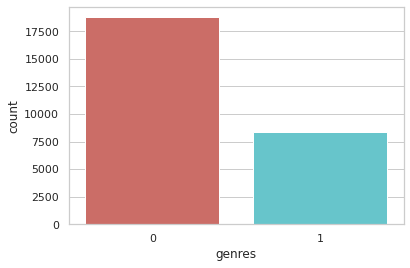

<Figure size 432x288 with 0 Axes>

In [76]:
sns.countplot (x='genres', data = movies_df, palette = 'hls')
plt.show()
plt.savefig('count-plot')

In [77]:
count_action = len(movies_df[movies_df['genres']==1])
count_horror = len(movies_df[movies_df['genres']==0])
pct_action = count_action/(count_action+count_horror)
print("percentage action", pct_action*100)
pct_horror = count_horror/(count_action+count_horror)
print("percentage horror", pct_horror*100)

percentage action 30.889281507656065
percentage horror 69.11071849234393


In [78]:
movies_df.drop(movies_df.columns [[0,1]], axis = 1, inplace = True)

In [79]:
y = movies_df['genres']
X = movies_df.drop('genres', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, random_state=21)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((19017, 1), (8151, 1), (19017,), (8151,))

In [80]:
df_balanc = pd.concat([X_train, y_train], axis=1)
df_balanc.head()

df_balanced = balanset_by_column(df_balanc, 'genres', [1,0])

In [81]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.602352
         Iterations 4
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.026     
Dependent Variable: genres           AIC:              32731.4251
Date:               2021-10-08 18:54 BIC:              32739.6349
No. Observations:   27168            Log-Likelihood:   -16365.   
Df Model:           0                LL-Null:          -16796.   
Df Residuals:       27167            LLR p-value:      nan       
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     4.0000                                       
-----------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
runtimeMinutes   -0.0081   0.0001 -66.3495 0.0000 -0.0084 -0.0079



In [82]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [83]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.69


In [84]:
metrics.f1_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred))

0.8178390137781002

**Вывод:Согласно проведенному анализу мы принимаем гипотизу Н1: средняя продолжительность фильма зависит от жанра, для фильмов во времееной категории от 90-240 мин. и жанров ужасы, боевик.**